In [33]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.ticker as mticker
plt.style.use('ggplot') 
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format 
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.set_option('display.max_colwidth', None)

In [2]:
# Read the dataset

data = pd.read_csv('customer_shopping_data.csv')
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [3]:
data['invoice_date'] = pd.to_datetime(data['invoice_date'])
data['invoice_year'] = data['invoice_date'].dt.year
data['invoice_month'] = data['invoice_date'].dt.strftime('%B')
data['total_revenue'] = data['quantity'] * data['price']
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,invoice_year,invoice_month,total_revenue
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,2022,May,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,December,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,2021,September,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,2021,May,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,2021,October,242.40


### What is the age distribution of male and female customers?

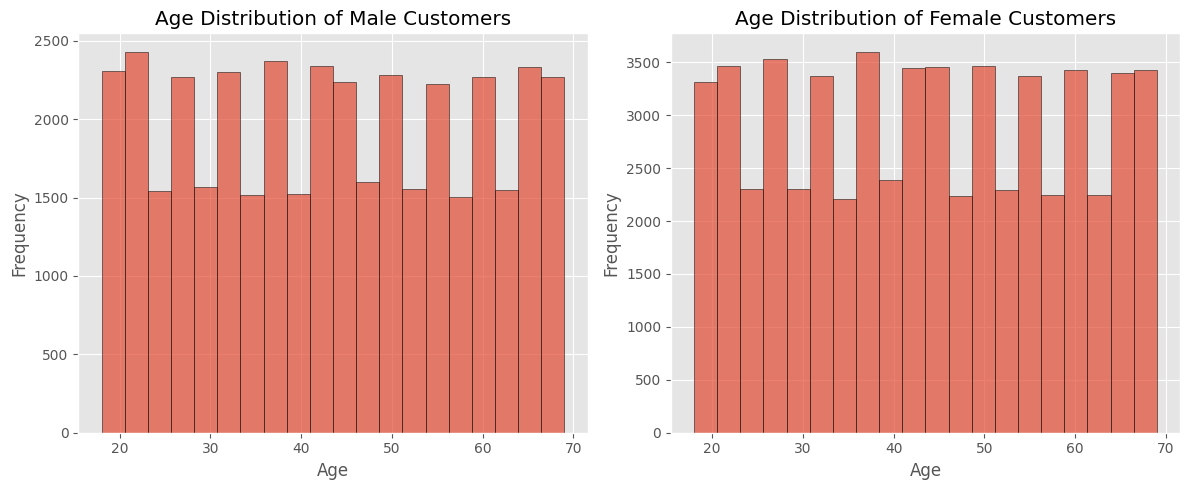

In [4]:
# Separate data into male and female groups
male_data = data[data['gender'] == 'Male']
female_data = data[data['gender'] == 'Female']

# Plot histograms for male and female age distributions
plt.figure(figsize=(12, 5))  # Adjust the figure size if needed

plt.subplot(1, 2, 1)
plt.hist(male_data['age'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Male Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(female_data['age'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Female Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()  # To prevent overlapping of subplots
plt.show()

In [5]:
# Check if there is significant difference between age of male and female customers

# Hypothesis
H0 = "There is a significant age difference between male and female customers."
H1 = "There is no significant age difference between male and female customers."
# Separate data into male and female groups
male_data = data[data['gender'] == 'Male']['age']
female_data = data[data['gender'] == 'Female']['age']

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=False)

# Set significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print(H0)
else:
    print(H1)

There is no significant age difference between male and female customers.


### Are there more male or female customers in each age group?

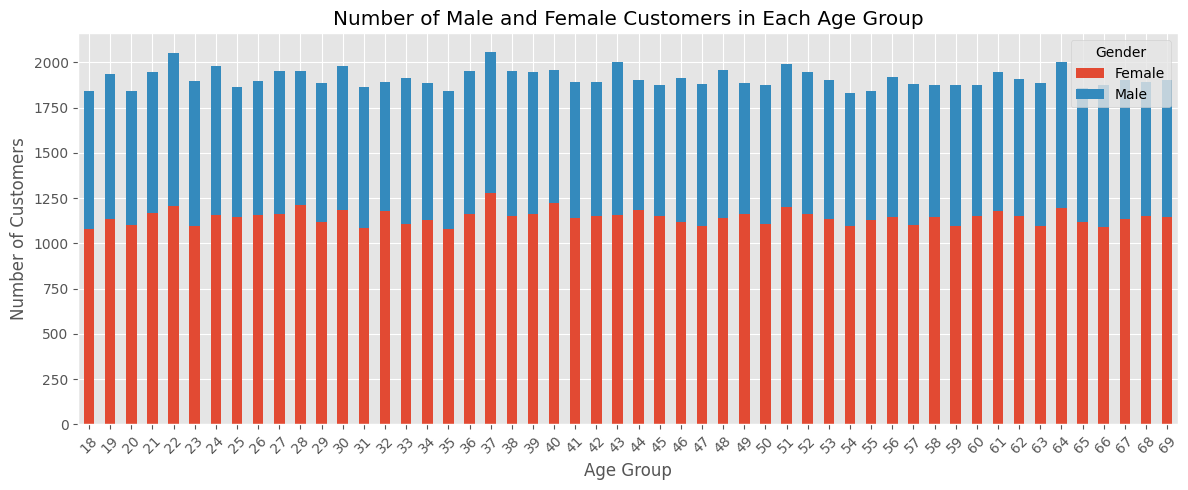

In [6]:
# Group data by 'age' and 'gender', and count the number of customers in each group
age_gender_counts = data.groupby(['age', 'gender']).size().unstack()

# Plot stacked bar plot
age_gender_counts.plot(kind='bar', stacked=True, figsize=(12, 5))
plt.title('Number of Male and Female Customers in Each Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.legend(title='Gender')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### How many new customers were acquired in the last quarter?

In [10]:
# Calculate the start and end dates of the last quarter
end_date = datetime(2023, 6, 30)
start_date = end_date - timedelta(days=90)

# Identify customers who made their first purchase within the last quarter
first_purchase_dates = data.groupby('customer_id')['invoice_date'].min()
new_customers_last_quarter = first_purchase_dates[
    (first_purchase_dates >= start_date) & (first_purchase_dates <= end_date)]


print("Number of new customers acquired in the last quarter:", len(new_customers_last_quarter))

Number of new customers acquired in the last quarter: 1180


### What is the average age of customers who make high-value purchases?

In [12]:
# Define a threshold for high-value purchases
high_value_threshold = 2000  # Adjust this threshold as needed

# Filter data for high-value purchases
high_value_customers = data[data['total_revenue'] >= high_value_threshold]

# Calculate the average age of customers making high-value purchases
average_age_high_value = high_value_customers['age'].mean()

print("Average age of customers making high-value purchases:", average_age_high_value)

Average age of customers making high-value purchases: 43.487727536055125


In [14]:

# Calculate total sales for each customer
data['total_revenue'] = data['quantity'] * data['price']
customer_total_sales = data.groupby('customer_id')['total_revenue'].sum()

# Divide customers into quartiles based on total sales
quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']
customer_total_sales_df = pd.DataFrame(customer_total_sales)
customer_total_sales_df['quartile'] = pd.qcut(customer_total_sales_df['total_revenue'], q=4, labels=quartile_labels)

# Merge customer ages with their corresponding quartile
customer_ages = data[['customer_id', 'age']].drop_duplicates()
customer_quartiles = customer_total_sales_df.merge(customer_ages, left_index=True, right_on='customer_id')

# Calculate the mean age for each quartile
mean_age_per_quartile = customer_quartiles.groupby('quartile')['age'].mean()

print("Mean age of customers for each quartile of total sales:")
print(mean_age_per_quartile)

Mean age of customers for each quartile of total sales:
quartile
Q1   43.49
Q2   43.30
Q3   43.45
Q4   43.47
Name: age, dtype: float64


### What is the average spending of customers aged 30-40?

In [15]:
# Filter data for customers aged 30-40
customers_age_30_40 = data[(data['age'] >= 30) & (data['age'] <= 40)]

# Calculate average spending for customers aged 30-40
average_spending_30_40 = customers_age_30_40['total_revenue'].mean()

print("Average spending of customers aged 30-40:", average_spending_30_40)

Average spending of customers aged 30-40: 2509.642112298207


### Can you identify any correlations between customer age and payment methods?

In [16]:
# Convert payment_method into one-hot encoded columns
payment_methods_encoded = pd.get_dummies(data['payment_method'], prefix='payment')

# Concatenate the one-hot encoded columns with the original data
data_with_encoded_payment = pd.concat([data, payment_methods_encoded], axis=1)

# Calculate the correlation matrix
correlation_matrix = data_with_encoded_payment[['age', 'payment_Credit Card', 'payment_Debit Card', 'payment_Cash']].corr()

# Extract the correlation between age and payment methods
correlation_age_payment = correlation_matrix['age'][1:]

print("Correlation between customer age and payment methods:")
print(correlation_age_payment)

Correlation between customer age and payment methods:
payment_Credit Card    0.00
payment_Debit Card    -0.00
payment_Cash           0.00
Name: age, dtype: float64


### Who are the top 10 customers in terms of lifetime spending?

In [19]:
# Calculate total spending for each customer
customer_total_spending = data.groupby('customer_id')['total_revenue'].sum()

# Sort customers based on total spending and get the top 10
top_10_customers = customer_total_spending.sort_values(ascending=False).head(10)

print("Top 10 customers in terms of lifetime spending:")
print(top_10_customers)

Top 10 customers in terms of lifetime spending:
customer_id
C137763   26250.00
C699580   26250.00
C110600   26250.00
C110625   26250.00
C211345   26250.00
C139344   26250.00
C700083   26250.00
C291511   26250.00
C291627   26250.00
C164347   26250.00
Name: total_revenue, dtype: float64


### What is the average spending of customers who shop in specific shopping malls?

In [21]:
# Choose the specific shopping mall(s) you're interested in
specific_malls = data['shopping_mall'].to_list()  # Replace with the desired shopping malls

# Filter data for customers who shop in the specific malls
customers_in_specific_malls = data[data['shopping_mall'].isin(specific_malls)]

# Calculate average spending for customers in the specific malls
average_spending_specific_malls = customers_in_specific_malls.groupby('shopping_mall')['total_revenue'].mean()

print("Average spending of customers in specific shopping malls:")
print(average_spending_specific_malls)

Average spending of customers in specific shopping malls:
shopping_mall
Cevahir AVM         2533.59
Emaar Square Mall   2578.69
Forum Istanbul      2487.15
Istinye Park        2517.01
Kanyon              2550.28
Mall of Istanbul    2550.89
Metrocity           2485.03
Metropol AVM        2497.78
Viaport Outlet      2548.10
Zorlu Center        2542.08
Name: total_revenue, dtype: float64


### Are there any noticeable patterns in the distribution of customer ages across shopping malls?

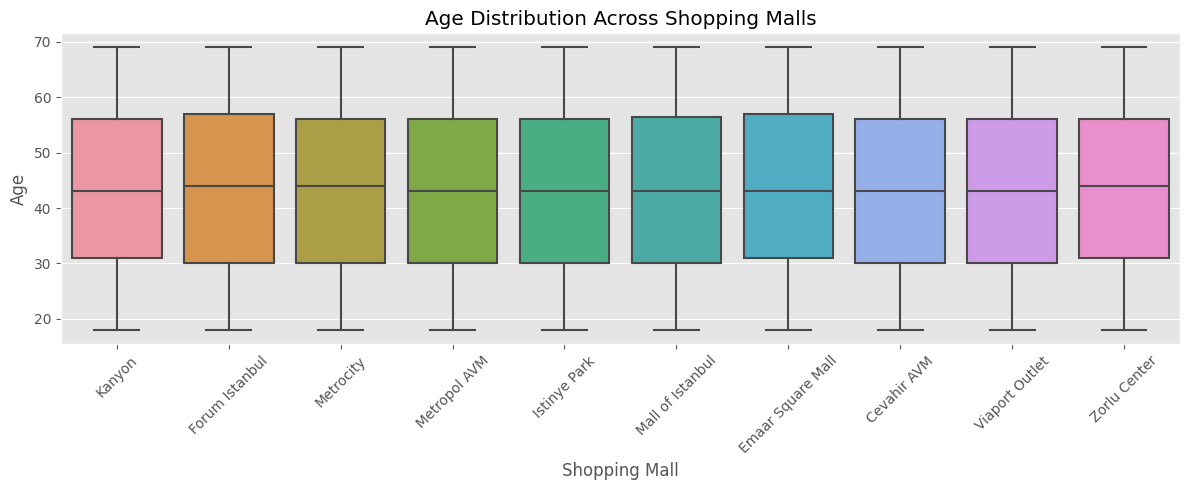

In [27]:
# Create box/violin plots to visualize age distribution across shopping malls
plt.figure(figsize=(12, 5))  # Adjust figure size if needed

sns.boxplot(x='shopping_mall', y='age', data=data)
plt.title('Age Distribution Across Shopping Malls')
plt.xlabel('Shopping Mall')
plt.ylabel('Age')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

### How has the customer base grown or shifted over the past year?

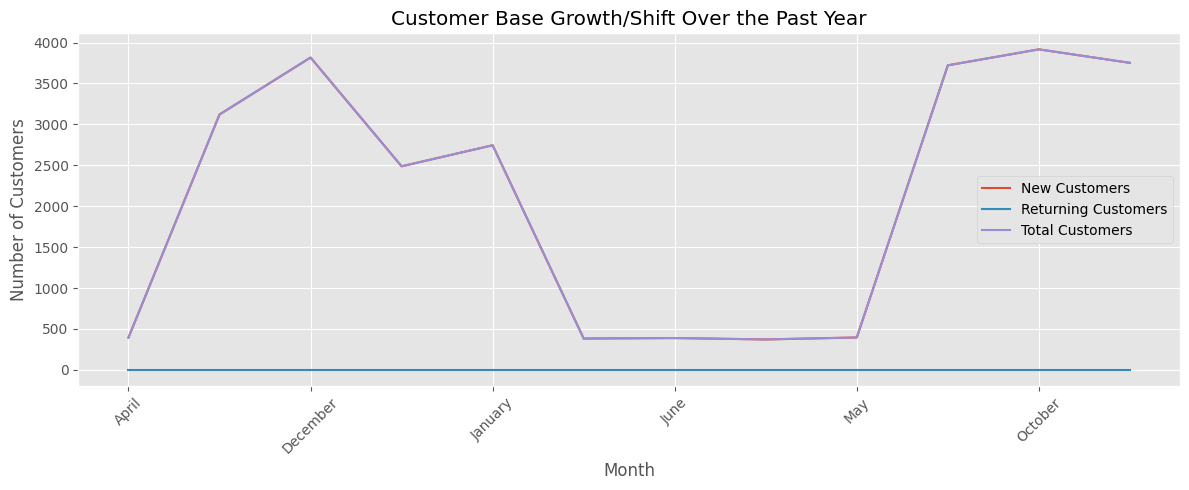

In [32]:

# Calculate the start and end dates of the past year
end_date = pd.to_datetime('2023-08-10')
start_date = end_date - pd.DateOffset(years=1)

# Filter data for the past year
past_year_data = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

# Group data by 'invoice_month' and 'customer_id'
monthly_customer_counts = past_year_data.groupby(['invoice_month', 'customer_id']).size().reset_index(name='count')

# Calculate new and returning customers for each month
customer_acquisition = monthly_customer_counts.groupby('invoice_month')['customer_id'].nunique()
customer_retention = monthly_customer_counts.groupby('invoice_month').apply(lambda x: (x['count'] > 1).sum())

# Calculate total customers in each month (new + returning)
total_customers = customer_acquisition + customer_retention

# Plot the growth/shift of the customer base over the past year
plt.figure(figsize=(12, 5))  # Adjust figure size if needed

customer_acquisition.plot(label='New Customers')
customer_retention.plot(label='Returning Customers')
total_customers.plot(label='Total Customers')

plt.title('Customer Base Growth/Shift Over the Past Year')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

Cluster Characteristics:
         total_revenue  quantity
cluster                         
0               697.70      2.62
1              8669.44      4.30


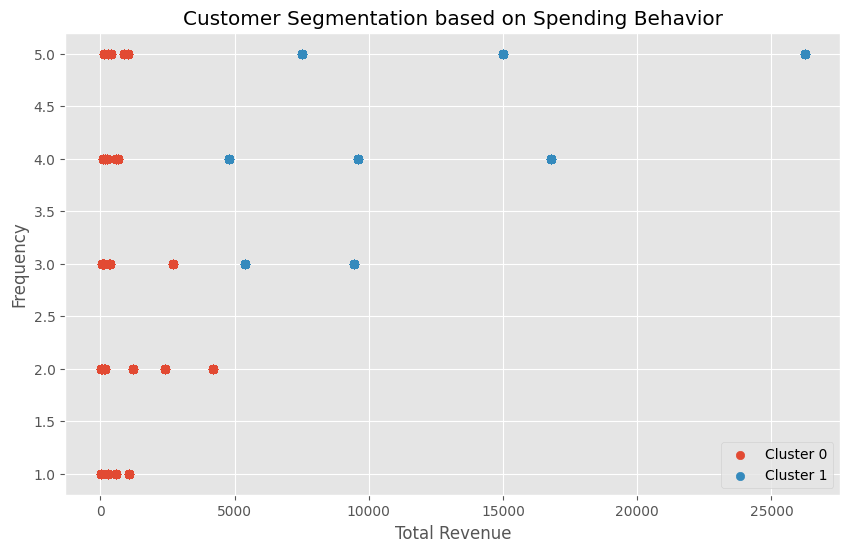

In [36]:
# Select relevant features for clustering (e.g., total spending and frequency)
features = ['total_revenue', 'quantity']  # Add other relevant columns

# Prepare the data for clustering
X = data[features]

# Choose the number of clusters (you can adjust this based on your data and business insights)
num_clusters = 2

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Analyze the clusters and their characteristics
cluster_means = data.groupby('cluster')[features].mean()

# Print cluster characteristics
print("Cluster Characteristics:")
print(cluster_means)

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    plt.scatter(
        data[data['cluster'] == cluster]['total_revenue'],
        data[data['cluster'] == cluster]['quantity'],
        label=f'Cluster {cluster}'
    )
plt.title('Customer Segmentation based on Spending Behavior')
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.legend()
plt.show()